In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Set up

In [3]:
import os
os.environ["PYTHONHASHSEED"] = "0"
import tqdm
import json
import joblib
import datetime
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, clone
from sklearn.compose import ColumnTransformer
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import RFECV, mutual_info_regression
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import norm

import catboost as cb
# import lightgbm as lgbm

from utils import load_config
from src.helpers import (
    ContiguousGroupKFold, 
    ContiguousTimeSeriesSplit,
    custom_log_likelihood, 
    compute_per_station_metrics, 
    get_station_stats, 
    standardize_values, 
    standardize_prediction_intervals, 
    compute_per_station_metrics, 
    summarize_metrics,
    compute_non_negative_log_likelihood,
    GroupMinMaxScaler,
    GroupStandardScaler
)

## Constants

In [4]:
config = load_config()

In [5]:
DATA_DIR = config['final_data']
TRAIN = os.path.join(DATA_DIR, 'train.csv')
TEST = os.path.join(DATA_DIR, 'eval.csv')

## Modelling

- Direct Regressor: Predicts outputs and prediction interval directly
  - GBT with quantile loss
  - deep learning with quantile loss
- Ensemble Regressor: Uses a monte-carlo simulation to generate prediction interval
  - GBT with ensemble
  - deep learning with ensemble
- CV ensemble modelling - fold cross validation

In [6]:
CV_SPLIT = 5

#### Load data

In [7]:
df = pd.read_csv(TRAIN)
df_test = pd.read_csv(TEST)

/tmp/ipykernel_917805/1427115751.py:1: DtypeWarning: Columns (35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAIN)
/tmp/ipykernel_917805/1427115751.py:2: DtypeWarning: Columns (35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(TEST)


In [8]:
# df['week'] = df.week.apply(lambda x: min(int(x), 52)).astype(str)
# df_test['week'] = df_test.week.apply(lambda x: min(int(x), 52)).astype(str)

In [9]:
CATEGORICAL = ['river', 'location', 'month', 'week', 'season', 'station_code']

In [10]:
for col in CATEGORICAL:
    df[col] = df[col].astype('str')
    df_test[col] = df_test[col].astype('str')

In [11]:
NUM_LOCATION = ['lat', 'lon', 'altitude']
NUM_SOIL = ['bdod', 'cfvo', 'clay', 'sand']
NUM_METEO = ['tp', 't2m', 'swvl1', 'evap']
COLS_TO_DROP = ['ObsDate', 'catchment', 'hydro_region', 'hydro_sector', 'hydro_sub_sector', 'hydro_zone', 'region_sector', 
    'region_sub_sector', 'region_zone', 'sector_sub_sector', 'sector_zone', 'sub_sector_zone']
TARGET_COLS = ['water_flow_week_1', 'water_flow_week_2', 'water_flow_week_3', 'water_flow_week_4']
LAG_COLS = ['water_flow_lag_1w', 'water_flow_lag_2w', 'water_flow_rolling_mean_4w']
CONTINUOUS_COLS = list(df.select_dtypes(['float', 'int']).drop(columns = TARGET_COLS + COLS_TO_DROP + LAG_COLS, errors = 'ignore').columns)

### Train Test Split
- Based on previous analysis, the dataset exhibits annual seasonality but no significant long-term trend.
- Therefore, it is acceptable to use chronological or block-wise splits without always reserving the most recent data for validation.
- This approach is appropriate for seasonally-repeating time series, where the assumption of trend-driven data drift does not hold.
- In such cases, the model's ability to generalize across seasonal cycles is more important than strict recency.

In [12]:
cgkf = ContiguousGroupKFold(5)
for idx, (train_ids, val_ids) in enumerate(cgkf.split(df, groups = df.year)):
    print(f'Years in fold {idx + 1}')
    print('Train:', *df.iloc[train_ids].year.unique())
    print('Validation:', *df.iloc[val_ids].year.unique())
    print('-------------------------------------------------------------------------')

Years in fold 1
Train: 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
Validation: 1990 1991 1992
-------------------------------------------------------------------------
Years in fold 2
Train: 1990 1991 1992 1996 1997 1998 1999 2000 2001 2002 2003 2004
Validation: 1993 1994 1995
-------------------------------------------------------------------------
Years in fold 3
Train: 1990 1991 1992 1993 1994 1995 1999 2000 2001 2002 2003 2004
Validation: 1996 1997 1998
-------------------------------------------------------------------------
Years in fold 4
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 2002 2003 2004
Validation: 1999 2000 2001
-------------------------------------------------------------------------
Years in fold 5
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
Validation: 2002 2003 2004
-------------------------------------------------------------------------


In [13]:
cgkf = ContiguousTimeSeriesSplit(5, 0.6)#, test_size = 2)
for idx, (train_ids, val_ids) in enumerate(cgkf.split(df, groups = df.year)):
    print(f'Years in fold {idx + 1}')
    print('Train:', *df.iloc[train_ids].year.unique())
    print('Validation:', *df.iloc[val_ids].year.unique())
    print('-------------------------------------------------------------------------')

Years in fold 1
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validation: 1999 2000 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 2
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
Validation: 2000 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 3
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
Validation: 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 4
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
Validation: 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 5
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
Validation: 2003 2004
-------------------------------------------------------------------------


### Models

In [14]:
class ChainedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, estimator_params, n_targets = None, chained = True):
        self.base_estimator = base_estimator
        self.estimator_params = estimator_params
        self.chained = chained
        self.n_targets = n_targets
        self.models_ = []

    def fit(self, X, y, eval_set=None, **fit_params):
        # X = np.array(X)
        # Y = np.array(y)
        self.models_ = []

        self.n_targets = y.shape[1]

        X_val, Y_val = None, None
        if eval_set:
            X_val, Y_val = eval_set[0]
            # X_val = np.array(X_val)
            # Y_val = np.array(Y_val)

        X_train_chain = X.copy()
        X_val_chain = X_val.copy() if eval_set else None

        for i in range(self.n_targets):
            params = self.estimator_params.copy()
            model = self.base_estimator(**params)
            y_train_i = y.iloc[:, i]

            # Resolve fit parameters (per target if needed)
            local_fit_params = {}
            for k, v in fit_params.items():
                if isinstance(v, (list, tuple)) and len(v) == self.n_targets:
                    local_fit_params[k] = v[i]
                else:
                    local_fit_params[k] = v

            if eval_set:
                y_val_i = Y_val.iloc[:, i]
                model.fit(
                    X_train_chain, y_train_i,
                    eval_set=[(X_val_chain, y_val_i)],
                    **local_fit_params
                )
            else:
                model.fit(X_train_chain, y_train_i, **local_fit_params)

            self.models_.append(model)
            if self.chained:
                y_pred_train = model.predict(X_train_chain).reshape(-1, 1)
                X_train_chain[f'pred_{i}'] = y_pred_train #np.hstack([X_train_chain, y_pred_train])

                if eval_set:
                    y_pred_val = model.predict(X_val_chain).reshape(-1, 1)
                    X_val_chain[f'pred_{i}'] = y_pred_val #np.hstack([X_val_chain, y_pred_val])

        return self

    def predict(self, X):
        X = np.array(X)
        X_chain = X.copy()
        preds = []

        for model in self.models_:
            y_pred = model.predict(X_chain).reshape(-1, 1)
            preds.append(y_pred)
            X_chain = np.hstack([X_chain, y_pred])

        return np.hstack(preds)

    def save_model(self, path):
        """Save the chained model to disk."""
        os.makedirs(path, exist_ok=True)

        meta = {
            'n_targets': self.n_targets,
            'estimator_params': self.estimator_params,
            'chained': self.chained,
            'model_paths': []
        }

        for idx, model in enumerate(self.models_):
            model_path = os.path.join(path, f"catboost_target_{idx}.cbm")
            model.save_model(model_path)
            meta['model_paths'].append(f"catboost_target_{idx}.cbm")

        with open(os.path.join(path, "metadata.json"), "w") as f:
            json.dump(meta, f)

    @classmethod
    def load_model(cls, path, base_estimator):
        """Load the chained model from disk."""
        with open(os.path.join(path, "metadata.json")) as f:
            meta = json.load(f)

        model = cls(base_estimator = base_estimator, estimator_params = meta['estimator_params'], chained = meta['chained'], n_targets=meta['n_targets'])
        model.models_ = []

        for model_file in meta['model_paths']:
            # cbm = clone(base_estimator)
            cbm = base_estimator()#**self.estimator_params)
            cbm.load_model(os.path.join(path, model_file))
            model.models_.append(cbm)

        return model

    def get_best_iter(self):
        return np.array([model.best_iter for model in self.models_])


In [15]:
def create_gbt_model(model_type = 'catboost', model_params = {}, chained = True):
    if model_type == 'catboost':
        base_model = cb.CatBoostRegressor#(*args, **kwargs)
    elif model_type == 'lightgbm':
        # base_model = lgbm.LGBMRegressor(*args, **kwargs)
        raise NotImplementedError
    elif model_type == 'xgboost':
        # base_model = xgb.XGBRegressor(*args, **kwargs)
        raise NotImplementedError
    else:
        raise ValueError('Unsupported model type')
    model = ChainedRegressor(base_model, model_params, chained = chained)
    return model
        

In [16]:
class BaseRegressor(ABC):
    def __init__(
        self, 
        model_fn = None, 
        model_params = None, 
        preprocessor = None, 
        cv = 5, 
        cv_group = 'year', 
        alphas = [0.05, 0.95], 
        method = 'indirect',
        n_models = 5,
        cat_features = None,
        exclude_cols = None,
        random_state = 42,
        bootstrap = True,
        delta = 0.01,
        patience = 5,
        split_type = 'time_series'
    ):
        self.model_fn = model_fn
        self.model_params = model_params
        self.preprocessor = preprocessor
        self.cv = cv
        self.cv_group = cv_group
        self.alphas = alphas
        self.method = method
        self.n_models = n_models
        self.cat_features = cat_features[::] if cat_features is not None else None
        self.exclude_cols = exclude_cols
        self.random_state = random_state
        self.bootstrap = bootstrap
        self.delta = delta
        self.patience = patience
        self.split_type = split_type
        # if self.model_params is not None:
        #     self.lr = self.model_params.pop('lr') if 'lr' in self.model_params.keys() else 0.01

        self.preprocessors = {}
        self.models = {}
        self.history = {}

    @abstractmethod
    def fit(self, X, y):           
        raise NotImplementedError

    @abstractmethod
    def predict(self, X):
        raise NotImplementedError

    @abstractmethod
    def save_model(self, save_path):
        raise NotImplementedError

    @abstractmethod
    def load_model(self, load_path):
        raise NotImplementedError

    @abstractmethod
    def prep_data_for_model(self, X):
        raise NotImplementedError

    def get_data(self, X, y, train_ids, val_ids):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        return X_train, X_val, y_train, y_val

    def cv_split(self, X, group):
        if self.split_type == 'time_series':
            cvf = ContiguousTimeSeriesSplit(self.cv, 0.6)
        elif self.split_type == 'group_kfold':
            cvf = ContiguousGroupKFold(self.cv)
        else:
            raise ValueError('`split_type` must be one of `time_series` or `group_kfold`')
        return cvf.split(X, groups = group)
        

In [137]:
class GBTEnsembleRegressor(BaseRegressor):
    def __init__(self, *args, model_type = 'catboost', lr = None, k = 12, chained = True, use_priors = False, enforce_location = True, location_column = None, min_patience = 20, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr
        if self.lr is not None:
            if self.method == 'direct':
                assert len(self.lr) == 3, '`len(lr)` must be 3 if method = direct'
            elif self.method == 'indirect':
                assert len(self.lr) == self.n_models, '`len(lr)` must be same as n_models'
        self.model_type = model_type
        self.chained = chained
        self.use_priors = use_priors
        self.enforce_location = enforce_location
        self.location_column = location_column
        if self.enforce_location:
            assert self.location_column is not None, '`location_column` is None! You must provide location_column present in your dataset'
        self.min_patience = min_patience
        self.results = {}
        self.residuals_ = []
        self.feature_names_ = None
        self.stations_df = None
        self.priors_df = None
        self.k = k
        self.kmeans = None

    def _prep_kmeans_data(self, X):
        assert 'station_code' in X.columns, 'X must contain `station_code` column!'
        assert 'longitude' in X.columns, 'X must containt `longitude` column!'
        assert 'latitude' in X.columns, 'X must contain `latitude` column!'
        data = X.groupby(['station_code', 'longitude', 'latitude']).agg(['mean', 'std']).reset_index().set_index('station_code')
        return data

    def _do_kmeans(self, X):
        X_ = self._prep_kmeans_data(X)
        km = Pipeline([
            ('scaler', MinMaxScaler()),
            ('kmeans', KMeans(self.k, random_state = 42))
        ])
        km.fit(X_)
        return km

    def _create_cluster_column(self, X, km, label_map = None):
        # copy dataset
        X = X.copy()
        # prepare and predict label
        X_ = self._prep_kmeans_data(X[self.km_columns])
        X_['labels'] = km.predict(X_)
        # align with label map
        if label_map is not None:
            X_['labels'] = X_['labels'].map(label_map)
        # merge to original dataframe
        X['cluster'] = X.station_code.map(X_.labels.to_dict()).astype('category')
        return X
        
    def _align_cluster_centers(self, gcc, cc):
        cost_matrix = pairwise_distances(cc, gcc)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        label_map = dict(zip(row_ind, col_ind))
        return label_map
        
    def fit(self, X, y, batch_size = 32, epochs = 100):

        self.stations_df = X.drop_duplicates(subset = 'station_code')[['station_code', 'river', 'location', 'river_ranking', 'latitude', 'longitude']]
        self.priors_df = self._compute_empirical_priors(X, y, target_col = 'water_flow_week_1')

        # kmeans
        self.km_columns = [i for i in X.columns if ('water_flow' in i and 'trend' not in i) or i in ['latitude', 'longitude', 'station_code']]
        data = X[self.km_columns]
        self.km = self._do_kmeans(data)
        global_cluster_centers = self.km['kmeans'].cluster_centers_
        self.cat_features.append('cluster')
    
        
        # split the data into folds
        splits = self.cv_split(X, X[self.cv_group])

        # loop through each fold
        for idx, (train_ids, val_ids) in enumerate(splits):
            print(f'---------------------FOLD {idx}-------------------------')
            # get fold data
            X_train, X_val, y_train, y_val = self.get_data(X, y, train_ids, val_ids)

            # do kmeans clustering
            X_train_km_data = X_train[self.km_columns]
            km = self._do_kmeans(X_train_km_data)
            label_map = self._align_cluster_centers(global_cluster_centers, km['kmeans'].cluster_centers_)
            X_train = self._create_cluster_column(X_train, km, label_map)
            X_val = self._create_cluster_column(X_val, km, label_map)
            print('Training on years:', *sorted(X_train.year.unique()))
            print('Validating on years:', *sorted(X_val.year.unique()))

            # get priors
            if self.use_priors:
                stations_df = X_train.drop_duplicates(subset = 'station_code')[['station_code', 'river', 'location', 'river_ranking', 'latitude', 'longitude']]
                priors_df = self._compute_empirical_priors(X_train, y_train, target_col = 'water_flow_week_1')
                X_train = self._compute_train_empirical_priors(X_train, y_train, target_col = 'water_flow_week_1')
                X_val = self._get_empirical_priors(X_val, priors_df, stations_df)

            # get station codes before preprocessing the data
            station_codes = X_val.station_code.values.tolist()
            
            # preprocess data
            if self.preprocessor is not None:                
                preprocessor = clone(self.preprocessor)
                X_train_ = preprocessor.fit_transform(X_train)
                X_val_ = preprocessor.transform(X_val)
    
                cols_ = preprocessor.get_feature_names_out()
                cols = [col.split('__')[-1] for col in cols_]
    
                X_train_ = pd.DataFrame(X_train_, columns = cols, index = y_train.index)
                X_val_ = pd.DataFrame(X_val_, columns = cols, index = y_val.index)

                # save preprocessor
                self.preprocessors[f'fold_{idx}'] = preprocessor

            X_train_ = self.prep_data_for_model(X_train_)
            X_val_ = self.prep_data_for_model(X_val_)
            # print(X_train_.columns)
            
            self.feature_names_ = list(X_train_.columns)
            if self.enforce_location:
                weights = self._get_feature_weights('location', self.feature_names_)
            else:
                weights = None

            # get the type of model to build, direct or indirect
            if self.method == 'direct':
                self.n_models = 3
                losses = [f'Quantile:alpha={self.alphas[0]}', 'Quantile:alpha=0.5', f'Quantile:alpha={self.alphas[1]}']
                od_wait = [self.patience // 5, self.patience, self.patience // 5]
                y_out = []
                for i in range(self.n_models):
                    print(f'Training model fold_{idx}_model_{i}')
                    # create model
                    model = self.build_model(self.model_type, loss_function = losses[i], eval_metric = 'MAE', lr = self.lr[i], od_wait = od_wait[i], feature_weights = weights, random_state = self.random_state)  # use quantile loss
                    # fit model
                    model.fit(X_train_, y_train, eval_set = [(X_val, y_val)])
                    # store model
                    self.models[f'fold_{idx}_model_{i}'] = model
                    print('----------------------------------------------------')
                    # store X_val predictions for evaluation
                    pred = model.predict(X_val_)
                    pred = np.clip(pred, 0, np.inf)
                    y_out.append(pred)
                y_pred = y_out[1].reshape(-1)
                y_lower = y_out[0].reshape(-1)
                y_upper = y_out[2].reshape(-1)

                # # get conformal scores
                # yv_ = y_val.values.reshape(-1)
                # # yv_ = np.expm1(yv_)
                # resids = np.maximum(y_lower - yv_, yv_ - y_upper) / (y_pred + 1)
                # self.residuals_.extend(resids)
                # delta = np.quantile(resids, self.alphas[1] - self.alphas[0])

                # # adjust results
                # y_out = np.sort(np.array([y_lower, y_pred, y_upper]), axis = 0)
                # y_pred = y_out[1]
                # y_lower = np.clip(y_out[0] - (delta * y_pred), 0, np.inf)  #self.delta
                # y_upper = np.clip(y_out[2] + (delta * y_pred), 0, np.inf) + 0.01 #self.delta
       
            elif self.method == 'indirect':
                y_out = []
                residuals_ = []
                for i in range(self.n_models):
                    SEED = i + idx*100
                    print(f'Training model fold_{idx}_model_{i}')
                    # create model
                    # quantiles = np.linspace(0.15, 0.85, self.n_models)
                    quantiles = norm.cdf(np.linspace(-0.5, 0.5, self.n_models))#np.linspace(-0.67449, 0.67449, self.n_models)
                    # losses = [f'Quantile:alpha={q}' for q in quantiles]
                    losses = ['MAE' for q in quantiles]
                    od_wait = np.clip((np.exp(-np.abs(np.arange(self.n_models) - (self.n_models / 2))) * self.patience).astype(int), self.min_patience, self.patience)
                    # od_wait = [50 for q in quantiles]
                    model = self.build_model(self.model_type, loss_function = losses[i], eval_metric = 'MAE', od_wait = int(od_wait[i]), feature_weights = weights, random_state = SEED)
                    # fit model
                    # X_, y_ = self._resample(X_train, y_train, random_state = SEED)
                    X_, y_ = X_train_.copy(), y_train.copy()
                    # # add multiplicative noise
                    # np.random.seed(SEED)
                    # X_['water_flow_lag_1w'] = X_.water_flow_lag_1w * np.random.uniform(0.99, 1.01, len(X_))
                    model.fit(X_, y_, eval_set = [(X_val_, y_val)])
                    # store model
                    self.models[f'fold_{idx}_model_{i}'] = model
                    print('----------------------------------------------------')
                    pred = model.predict(X_val_)
                    pred = np.clip(pred, 0, np.inf)
                    y_out.append(pred)
                y_out = np.stack(y_out, axis = 1)
                y_pred = np.mean(y_out, axis = 1).reshape(-1)
                y_lower = np.quantile(y_out, self.alphas[0], axis = 1).reshape(-1) #- self.delta
                y_upper = np.quantile(y_out, self.alphas[1], axis = 1).reshape(-1) #+ self.delta
                
            yv_ = y_val.values.reshape(-1)

            # conformal calibration
            relative_residuals = np.maximum(y_lower - yv_, yv_ - y_upper) / (y_pred + 1e-2)
            residuals_df = pd.DataFrame({'cluster': np.repeat(X_val.cluster.values, y_val.shape[1]), 'residuals': relative_residuals})
            self.residuals_.append(residuals_df)

            # compute residuals per cluster for each group
            residuals_per_cluster = residuals_df.groupby('cluster', observed = True).residuals.quantile(0.9)
            print(residuals_per_cluster)
            residuals_df['delta'] = residuals_df.cluster.map(residuals_per_cluster.to_dict()).astype('float')
            print('Empirical Coverage:', np.mean((y_lower <= yv_) & (y_upper >= yv_)))
            
            y_lower = np.clip(y_lower - (residuals_df.delta * y_pred), 0, np.inf) #self.delta
            y_upper = np.clip(y_upper + (residuals_df.delta * y_pred), 0, np.inf) + 0.01 #self.delta
                
            # compute per fold evaluation on nll
            # compute oof results
            y_true = y_val.values.reshape(-1)
            y_quantiles = np.array(list(zip(y_lower, y_upper)))
            station_codes = np.repeat(station_codes, y_val.shape[1])
            station_stats = get_station_stats(y_true, station_codes)
            nll = compute_non_negative_log_likelihood(
                pd.Series(y_true),
                y_pred, 
                y_quantiles,
                station_codes,
                station_stats,
                alpha = 0.1
            )
            self.results[f'fold_{idx}'] = nll
            print('-------------------------------------------------')
            print(f'Fold {idx} NLL:', nll, 'delta:', residuals_per_cluster.mean())

        # get delta
        global_residuals = pd.concat(self.residuals_)
        self.delta = global_residuals.groupby('cluster').residuals.quantile(self.alphas[1] - self.alphas[0]).to_dict()
        self.delta = {str(k):float(v) for k, v in self.delta.items()}
        print('Conformal adjustment:', self.delta)

    def predict(self, X):
        results = {}
        # create a copy of the test set
        X = X.copy() 
        X = self._create_cluster_column(X, self.km, None)
        if self.use_priors:
            X = self._get_empirical_priors(X, self.priors_df, self.stations_df)                
        for idx in range(self.cv):
            # copy the new data for each fold
            X_ = X.copy()
            if len(self.preprocessors) > 0:
                preprocessor = self.preprocessors[f'fold_{idx}']
                X_ = preprocessor.transform(X_)
                cols_ = preprocessor.get_feature_names_out()
                cols = [col.split('__')[-1] for col in cols_]
                X_ = pd.DataFrame(X_, columns = cols)
            X_ = self.prep_data_for_model(X_)
            for i in range(self.n_models):
                model = self.models[f'fold_{idx}_model_{i}']
                pred = np.clip(model.predict(X_), 0, np.inf)
                print(pred.mean(axis = 0))
                results[f'fold_{idx}_model_{i}'] = pred
                
        # aggregate by method.
        results_ = np.stack(list(results.values()), axis = 1)
        delta = X.cluster.astype(str).map(self.delta).values.reshape(-1, 1)
        if self.method == 'indirect':
            mean_result = results_.mean(axis = 1) #np.median(results_, axis = 1) #
            q_1 = np.quantile(results_, q = self.alphas[0], axis = 1) - (delta * mean_result)
            q_3 = np.quantile(results_, q = self.alphas[1], axis = 1) + (delta * mean_result)
            print(q_1)
            print(self.delta)
            print(delta * mean_result)
            out = {'pred' : mean_result, 'inf' : q_1, 'sup' : q_3}
        elif self.method == 'direct':
            results_ = results_.reshape(X.shape[0], self.cv, 3, -1)
            results_ = results_.mean(axis = 1)
            # results_ = results_[:, 4, :, :]
            print((results_[:, 2, :] - results_[:, 0, :]).mean(axis = (0, -1)))
            mean_pred = results_[:, 1, :]
            q_1 = results_[:, 0, :] - (delta * mean_pred)
            q_3 = results_[:, 2, :] + (delta * mean_pred)
            out = {'pred': mean_pred, 'inf': q_1, 'sup': q_3}
        return out, results_

    def save_model(self, save_path):
        os.makedirs(save_path, exist_ok=True)

        # save metadata
        metadata = {
            'method': self.method,
            'n_models': self.n_models,
            'alphas': self.alphas,
            'cv': list(self.preprocessors.keys()),
            'cat_features': self.cat_features,
            'exclude_cols': self.exclude_cols,
            'enforce_location': self.enforce_location,
            'location_column': self.location_column,
            'random_state': self.random_state,
            'bootstrap': self.bootstrap,
            'model_type': self.model_type,
            'feature_names': self.feature_names_,
            'results': self.results,
            'delta': self.delta,
            'patience': self.patience,
            'min_patience': self.min_patience,
            'split_type': self.split_type,
            'chained': self.chained,
            'k': self.k,
            'km_columns': self.km_columns
        }
        with open(os.path.join(save_path, 'metadata.json'), 'w') as f:
            json.dump(metadata, f)

        self.priors_df.to_csv(os.path.join(save_path, 'priors.csv'), index = False)
        self.stations_df.to_csv(os.path.join(save_path, 'stations.csv'), index = False)
    
        # save each model
        for name, model in self.models.items():
            model_path = os.path.join(save_path, name)
            model.save_model(model_path)
    
        # save each preprocessor
        for name, preprocessor in self.preprocessors.items():
            joblib.dump(preprocessor, os.path.join(save_path, f'{name}_preprocessor.pkl'))

        # save kmeans object
        joblib.dump(self.km, os.path.join(save_path, 'kmeans.pkl'))

    def load_model(self, load_path, model_fn, model_params):
         # Load metadata
        with open(os.path.join(load_path, 'metadata.json'), 'r') as f:
            metadata = json.load(f)
    
        self.method = metadata['method']
        self.n_models = metadata['n_models']
        self.alphas = metadata['alphas']
        self.cat_features = metadata['cat_features']
        self.exclude_cols = metadata['exclude_cols']
        self.random_state = metadata['random_state']
        self.bootstrap = metadata['bootstrap']
        self.model_type = metadata['model_type']
        self.feature_names_ = metadata['feature_names']
        self.results = metadata['results']
        self.delta = metadata['delta']
        self.patience = metadata['patience']
        self.min_patience = metadata['min_patience']
        self.split_type = metadata['split_type']

        self.model_fn = model_fn
        self.model_params = model_params
        self.chained = metadata['chained']
        self.k = metadata['k']
        self.km_columns = metadata['km_columns']
        
        self.preprocessors = {}
        self.models = {}

        self.stations_df = pd.read_csv(os.path.join(load_path, 'stations.csv'))
        self.priors_df = pd.read_csv(os.path.join(load_path, 'priors.csv'))

        # Load models
        for fold in metadata['cv']:
            for i in range(self.n_models):
                model_name = f'{fold}_model_{i}'
                model_path = os.path.join(load_path, model_name)
                model = self.build_model(self.model_type, random_state = self.random_state)
                cbm = model.__class__
                base_estimator = self.get_gbt_estimator()
                model = cbm.load_model(model_path, base_estimator)
                self.models[model_name] = model
    
            # Load preprocessor
            preproc_path = os.path.join(load_path, f'{fold}_preprocessor.pkl')
            self.preprocessors[fold] = joblib.load(preproc_path)

        # load kmeans object
        self.km = joblib.load(os.path.join(load_path, 'kmeans.pkl'))
                    
    def prep_data_for_model(self, X):
        # for deep learning convert categorical and continuous into a list of inputs
        X = X.copy()
        for col in self.cat_features:
            X[col] = X[col].astype('object').astype('category')
        return X

    def build_model(self, model_type = 'catboost', loss_function = 'MAE', eval_metric = 'MAE', lr = 0.3, od_wait = 10, feature_weights = None, random_state = 42):
        model_params = self.model_params.copy()
        if model_type == 'catboost':
            model_params.update({
                # 'objective': loss_function, #'MultiRMSE',
                'loss_function': loss_function, 
                'eval_metric': eval_metric, 
                # 'model_type': self.model_type, 
                'cat_features': self.cat_features,
                'random_state': random_state,
                'od_wait': od_wait,
                'learning_rate': lr,
                'feature_weights' : feature_weights
            })
        elif model_type == 'lightgbm':
            raise NotImplementedError
        elif model_type == 'xgboost':
            raise NotImplementedError
        else:
            raise ValueError('Unsupported model type')
        model = self.model_fn(self.model_type, model_params, chained = self.chained)
        return model

    def _resample(self, X, y, random_state = 42):
        if self.bootstrap:
            np.random.seed(random_state)
            idx = np.random.choice(X.index, len(X), replace = True)
            X_ = X.loc[idx, :]
            y_ = y.loc[idx, :]
        else:
            X_ = X.copy()
            y_ = y.copy()
        return X_, y_

    def get_gbt_estimator(self):
        if self.model_type == 'catboost':
            model = cb.CatBoostRegressor#()
        elif self.model_type == 'lightgbm':
            raise NotImplementedError
        elif self.model_type == 'xgboost':
            raise NotImplementError
        else:
            raise ValueError('Unsupported model type')
        return model

    def get_feature_names_(self):
        return self.feature_names_

    def get_feature_importances_(self):
        # Collect all importances into a list
        importances = [
            model.get_feature_importance()
            for fold_model in self.models.values()
            for model in fold_model.models_
        ]

        importances = [i[:len(self.feature_names_)] for i in importances]
        mean_importance = np.mean(importances, axis=0)
        feature_names = self.get_feature_names_()
    
        return pd.DataFrame({
            'features': feature_names,
            'importances': mean_importance
        }).sort_values(by='importances', ascending=False).reset_index(drop=True)
    
    def _compute_empirical_priors(self, X, y, target_col = None):
        assert 'week' in list(X.columns), 'X must contain week column'
        assert 'year' in list(X.columns), 'X must contain year column'
        assert 'station_code' in list(X.columns), 'X must contain station_code column'

        # join target and data
        tmp = pd.concat([X, y], axis = 1)

        # compute data pivot
        tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
        tmp = tmp.reset_index()
        tmp.columns = tmp.columns.rename('')
        return tmp

    def _compute_train_empirical_priors(self, X, y, target_col = None):
        assert 'week' in list(X.columns), 'X must contain week column'
        assert 'year' in list(X.columns), 'X must contain year column'
        assert 'station_code' in list(X.columns), 'X must contain station_code column'
        
        empirical_data = []

        # join target and data
        X = X.copy()
        X_ = pd.concat([X, y], axis = 1)
        stations = X_.station_code.unique()
        for station in stations:
            tmp = X_[X_.station_code == station][['year', 'week', 'river', target_col]].reset_index(drop = True)
            river = tmp.river.unique()[0]
            tmp = tmp.pivot_table(index = 'year', columns = 'week', values = target_col)   
            for year in X_.year.unique():
                tmp_ = tmp.drop(year)
                mean_annual_discharge = tmp_.mean(axis = 0)
                tmp_ = pd.DataFrame(mean_annual_discharge, columns = ['empirical_flow'])
                tmp_['year'] = year
                tmp_['station_code'] = station
                tmp_ = tmp_.reset_index().rename(columns = {'index':'week'})
                empirical_data.append(tmp_)
        emp = pd.concat(empirical_data, axis = 0)
        X = X.merge(emp, on = ['station_code', 'year', 'week'], how = 'left')
        return X
        
    def _get_empirical_priors(self, X, priors, stations_gdf):
        assert 'week' in list(X.columns), 'X must contain week column'
        assert 'year' in list(X.columns), 'X must contain year column'
        assert 'station_code' in list(X.columns), 'X must contain station_code column'

        X = X.copy()
        priors.columns = [str(i) for i in priors.columns]
        
        emp_ = []
        for station in X.station_code.unique():
            if station in list(priors.columns):
                data = priors[['week', station]]
                data = data.rename(columns = {station: 'empirical_flow'})
                data['station_code'] = station
            else:
                # get nearest stations by river
                tmp = X[X.station_code == station]
                river = tmp.river.unique()[0]
                rank = tmp.river_ranking.unique()[0]
                location = tmp.location.unique()[0]
                coords = tmp[['latitude', 'longitude']].drop_duplicates()
                # get is same river & is same rank
                # is same river works because the train stations are also present in the eval set
                is_same_river = stations_gdf[stations_gdf.river == river].station_code
                if location == 'france':
                    is_same_rank = stations_gdf[(stations_gdf.river_ranking.isin([rank, rank+1])) & (stations_gdf.location == location)].station_code
                elif location == 'brazil':
                    is_same_rank = stations_gdf[(stations_gdf.river_ranking.isin([rank])) & (stations_gdf.location == location)].station_code

                # get neighbors list
                neighbors_list = np.unique(np.concatenate([is_same_river, is_same_rank]))
                
                # get neighbors coords
                neighbors_df = stations_gdf[stations_gdf.station_code.isin(neighbors_list)][['latitude', 'longitude', 'river', 'station_code']]

                # compute nearest neighbors and get 2 nearest stations
                nn = NearestNeighbors(n_neighbors=2, radius = 1, metric='euclidean')
                nn.fit(neighbors_df[['latitude', 'longitude']])

                # get distances and neighbor indices
                distances, indices = nn.kneighbors(coords)
                neighbors = neighbors_df.iloc[indices[0]]

                # compute inverse distance for weighting
                inv_distance = 1 / np.maximum(distances[0], 1e-6)**1
                weights = inv_distance / inv_distance.sum()
                neighbors['weights'] = weights

                data = priors.set_index('week')[neighbors.station_code.astype(str).values]* neighbors.weights.values
                data['empirical_flow'] = data.mean(axis = 1)
                data = data.reset_index()[['week', 'empirical_flow']]
                data['station_code'] = station

            emp_.append(data)
        emp_ = pd.concat(emp_)
        emp_['week'] = emp_.week.astype(str)
        X = X.merge(emp_, on = ['station_code', 'week'], how = 'left')
        return X

    def _compute_interactions(self, X, col1, col2):
        X[f'{col1}_{col2}_interaction'] = X[col1] * X[col2]       

    def _get_feature_weights(self, location_feature, columns):
        return [200 if i == location_feature else 1 for i in columns]

### Feature Selection

In [18]:
X_ = df.drop(columns = TARGET_COLS + COLS_TO_DROP + CATEGORICAL, errors = 'ignore')
y_= df.water_flow_week_1

In [19]:
# corr_matrix = X_.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# # Find features with correlation > 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# # Drop them before RFE
# X_filtered = X_.drop(columns=to_drop)
# X_filtered = X_[sorted(X_filtered.columns)]

In [20]:
# plt.figure(figsize = (15, 15))
# sns.heatmap(X_filtered.corr())

### Select features using mutual_information_regression and RFE
- MIR to select most correlated features with the target from soil and meteo
- RFE to refine to only most important variables

In [21]:
FEATURE_GROUPS = [NUM_SOIL, NUM_METEO]

In [22]:
X_.tp_sub_sector.mean()
X_.isna().any().sum()

0

In [23]:
%%time
selected_features = []
for feature_group in FEATURE_GROUPS:
    XX = X_.filter(regex = '|'.join(feature_group))
    features = np.array(XX.columns)
    mi = mutual_info_regression(XX, y_)
    select_idx = np.where(mi > np.quantile(mi, 0.5))[0]
    feature_imp = mi[select_idx]
    features = features[select_idx]
    features_ranked = sorted(zip(features, feature_imp), key = lambda x: x[1], reverse = True)
    selected_features.extend(features_ranked)
selected_features_df = pd.DataFrame(selected_features, columns = ['feature', 'y_corr'])

CPU times: user 1min, sys: 172 ms, total: 1min
Wall time: 1min


In [24]:
# plt.figure(figsize = (15, 5))
# sns.barplot(selected_features_df, x = 'feature', y = 'y_corr')
# plt.tick_params(rotation = 90)

In [25]:
new_features = selected_features_df.feature.tolist()
new_features = new_features + [i for i in X_.columns if 'water_flow' in i]
len(new_features)

220

In [26]:
X_new = X_[new_features]

In [87]:
from sklearn.feature_selection import SelectFromModel
np.random.seed(0)
reg = cb.CatBoostRegressor(
    iterations = 100, 
    depth = 6,
    objective = 'MAE', 
    eval_metric = 'MAE', 
    verbose = 0, 
    random_state = 42, 
    thread_count = 1, 
    task_type = "CPU",
)
sfm = SelectFromModel(reg, threshold="median", max_features = 20)
sfm.fit(X_new, y_)
# X_selected = sfm.transform(X)

SelectFromModel(estimator=<catboost.core.CatBoostRegressor object at 0x7fe238befb00>,
                max_features=20, threshold='median')

In [88]:
sfm.get_feature_names_out()

array(['sand_30-60cm_mean_1km_mean', 'clay_5-15cm_mean_1km_std',
       'cfvo_100-200cm_mean_zone_std', 'clay_5-15cm_mean_zone_std',
       'cfvo_100-200cm_mean_5km_mean', 'cfvo_30-60cm_mean_5km_std',
       'bdod_5-15cm_mean_1km_std', 'cfvo_5-15cm_mean_25km_std',
       'bdod_100-200cm_mean_25km_std', 'cfvo_60-100cm_mean_5km_std',
       'swvl1_sub_sector', 'swvl1_region', 'swvl1_sector',
       'water_flow_lag_1w', 'water_flow_lag_2w', 'water_flow_lag_3w',
       'water_flow_lag_4w', 'water_flow_rolling_mean_4w',
       'water_flow_rolling_min_4w', 'water_flow_rolling_max_4w'],
      dtype=object)

(220, 2)

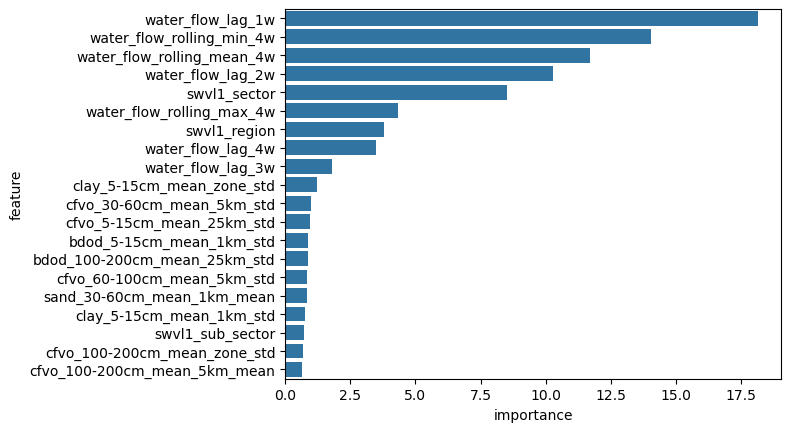

In [89]:
feat_import = pd.DataFrame({'feature': X_new.columns, 'importance': sfm.estimator_.feature_importances_})
feat_import = feat_import.sort_values('importance', ascending = False)
feat_import = feat_import[feat_import.importance >= 0]
sns.barplot(feat_import.iloc[:20], x = 'importance', y = 'feature')
feat_import.shape

In [130]:
selected_features_ = list(sfm.get_feature_names_out())
X_train = df[selected_features_ + CATEGORICAL + ['year', 'latitude', 'longitude', 'river_ranking'] + COLS_TO_DROP]
y_train = df[TARGET_COLS]

In [131]:
X_train.shape, y_train.shape

((28509, 42), (28509, 4))

In [132]:
selected_features_

['sand_30-60cm_mean_1km_mean',
 'clay_5-15cm_mean_1km_std',
 'cfvo_100-200cm_mean_zone_std',
 'clay_5-15cm_mean_zone_std',
 'cfvo_100-200cm_mean_5km_mean',
 'cfvo_30-60cm_mean_5km_std',
 'bdod_5-15cm_mean_1km_std',
 'cfvo_5-15cm_mean_25km_std',
 'bdod_100-200cm_mean_25km_std',
 'cfvo_60-100cm_mean_5km_std',
 'swvl1_sub_sector',
 'swvl1_region',
 'swvl1_sector',
 'water_flow_lag_1w',
 'water_flow_lag_2w',
 'water_flow_lag_3w',
 'water_flow_lag_4w',
 'water_flow_rolling_mean_4w',
 'water_flow_rolling_min_4w',
 'water_flow_rolling_max_4w']

In [133]:
gbt_transformer = ColumnTransformer(
    [
        ('scaler', MinMaxScaler(), list(X_train.drop(columns = CATEGORICAL + COLS_TO_DROP + TARGET_COLS + [i for i in X_train.columns if 'water_flow_lag' in i or 'water_flow_rolling' in i] + ['river_ranking'], errors = 'ignore').columns) ),   
        ('drop_cols', 'drop', COLS_TO_DROP)
    ],
    remainder = 'passthrough'
)

### hyp tuning

In [42]:
val_years = [1992, 1995, 1988, 2001]
X_train_part = X_train[~X_train.year.isin(val_years)] 
X_val_part = X_train[X_train.year.isin(val_years)]
y_train_part = y_train.loc[X_train_part.index].iloc[:, 0]
y_val_part = y_train.loc[X_val_part.index].iloc[:, 0]

X_train_part = X_train_part.drop(columns = COLS_TO_DROP, errors = 'ignore')
X_val_part = X_val_part.drop(columns = COLS_TO_DROP, errors = 'ignore')

In [43]:
# 🔍 Objective function for Optuna
def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.5, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 2.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'max_leaves': trial.suggest_int('max_leaves', 31, 128),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 50),

        'grow_policy': 'Lossguide',
        'loss_function': 'Huber:delta=10',
        'eval_metric': 'MAE',
        'early_stopping_rounds': 50,
        'verbose': 0,
        'task_type': 'CPU',  # Set to 'GPU' if you have GPU support
        'random_seed': 42
    }

    train_pool = cb.Pool(X_train_part, y_train_part, cat_features=CATEGORICAL)
    val_pool = cb.Pool(X_val_part, y_val_part, cat_features=CATEGORICAL)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)

    preds = model.predict(X_val_part)
    # rmse = mean_squared_error(y_val_part, preds, squared=False)
    mae = mean_absolute_error(y_val_part, preds)
    return mae

In [44]:
# # optimization
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# # best parameters
# print("Best trial:")
# print(f"  Value (MAE): {study.best_trial.value}")
# print(f"  Params: {study.best_trial.params}")

### Test KMeans

In [45]:
sta = X_train.groupby(['station_code', 'latitude', 'longitude', 'river'])[[i for i in X_train.columns if 'water_flow' in i and 'trend' not in i]].agg(['mean', 'std']).reset_index()

In [46]:
sta_test = df_test.drop(columns = 'water_flow_trend_4w').groupby(['station_code', 'latitude', 'longitude', 'river'])[[i for i in X_train.columns if 'water_flow' in i and 'trend' not in i]].agg(['mean', 'std']).reset_index()

In [47]:
wcss = []
distortions = []
for k in range(2, 20):
    km = KMeans(k, random_state = 42)
    data = sta.drop(columns = ['station_code', 'river'])
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    km.fit(data)
    wcss.append(km.inertia_)
    distortions.append(sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1)**2) / sta.shape[0])    

/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_code', 'river'])
/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_code', 'river'])
/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_code', 'river'])
/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_code', 'river'])
/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_co

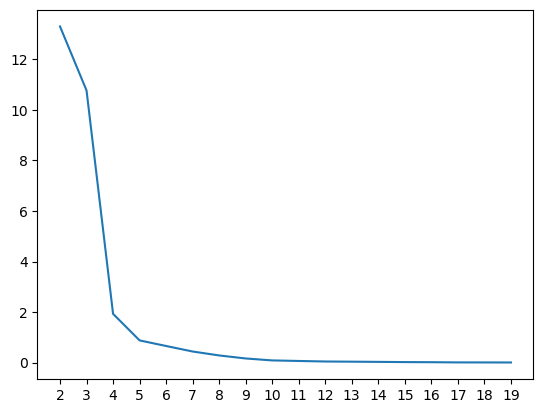

In [48]:
plt.plot([str(i) for i in range(2, 20)], wcss)

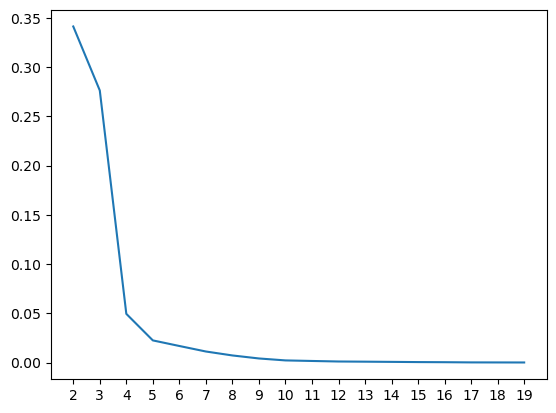

In [49]:
plt.plot([str(i) for i in range(2, 20)], distortions)

In [50]:
km = KMeans(12, random_state = 42)
km.fit(data)

KMeans(n_clusters=12, random_state=42)

In [51]:
km.labels_

array([ 8,  8, 10, 10,  8,  9, 10, 10, 10, 10, 10, 10,  0,  0,  0,  0,  0,
        0,  0,  0,  4,  9,  0,  0,  0,  0,  0,  0,  0,  5,  6, 11,  2,  3,
        7, 11,  2,  2,  1], dtype=int32)

In [52]:
sta['cluster'] = km.labels_
sta.cluster = sta.cluster.astype(str)

<Axes: xlabel="('longitude', '')", ylabel="('latitude', '')">

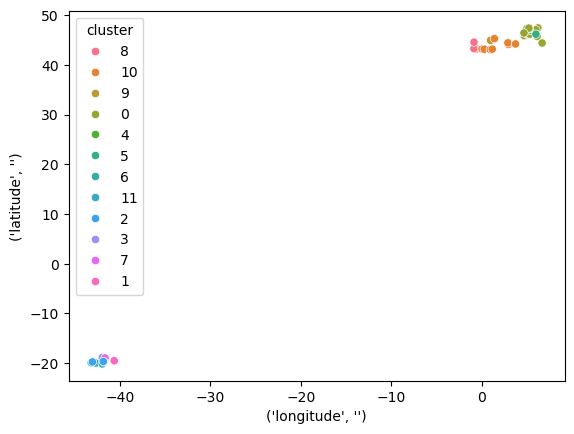

In [53]:
sns.scatterplot(sta, x = sta.columns[2], y = sta.columns[1], hue = 'cluster')

In [54]:
sta

station_code   latitude  longitude                   river  \
                                                                
0       6119020  43.187673  -0.597133            GAVE D'OSSAU   
1       6119040  43.245943  -0.874859                  SAISON   
2       6119110  43.174601   0.021673                   ECHEZ   
3       6119120  43.130613   0.258760                   ARROS   
4       6119200  44.547197  -0.872012                   LEYRE   
5       6124501  44.903011   0.959108                  VEZERE   
6       6124510  45.261184   1.380188                  ROSEIX   
7       6125220  43.045302   0.928175                   ARBAS   
8       6125320  44.080767   2.921202                    MUZE   
9       6125440  43.143790   1.141343                    VOLP   
10      6125630  44.414793   2.871969                   SERRE   
11      6139061  44.190360   3.715498  GARDON DE SAINTE-CROIX   
12      6139261  44.383261   6.651729                   UBAYE   
13      6139360  45.873299   4.642701                AZERGUES   
14      6139361  45.857683   4.687041                AZERGUES   
15      6139520  46.647213   5.774708                HERISSON   
16      6139550  46.155892   4.996680                   RENON   
17      6139560  46.118646   5.198074                   VEYLE   
18      6139640  46.170688   5.289284               REYSSOUZE   
19      6139681  47.414957   6.180271                   OGNON   
20      6139770  46.921595   5.350136                   DOUBS   
21      6139790  47.042646   5.814381                    LOUE   
22      6139795  47.030753   5.956855                   LISON   
23      6139825  45.719755   6.102802                  CHERAN   
24      6139900  47.237003   5.220392                  NORGES   
25      6139910  47.331788   4.980221                   OUCHE   
26      6139920  47.279504   5.216943                   TILLE   
27      6139921  47.372137   5.188617                   TILLE   
28      6139940  46.403242   4.648328                  GROSNE   
29      6939050  46.153000   5.970700                   RHONE   
30     56425000 -19.994400 -42.674400                RIO DOCE   
31     56610000 -19.931700 -43.173100          RIO PIRACICABA   
32     56659998 -19.765600 -43.032800          RIO PIRACICABA   
33     56850000 -18.883100 -41.950800                RIO DOCE   
34     56920000 -18.971100 -41.641700                RIO DOCE   
35     56960005 -20.170600 -41.961100            RIO MANHUAÇU   
36     56976000 -19.743100 -41.785300            RIO MANHUAÇU   
37     56978000 -19.678600 -41.835800            RIO MANHUAÇU   
38     56994500 -19.533300 -40.629700                RIO DOCE   

   water_flow_lag_1w             water_flow_lag_2w              \
                mean         std              mean         std   
0          18.013436   13.067202         18.002154   13.071798   
1          22.798011   20.811791         22.754460   20.814532   
2           1.221014    1.106043          1.219644    1.106430   
3           3.326129    3.272375          3.321516    3.273591   
4          16.565077   14.689473         16.548929   14.693359   
5          60.161827   54.168896         60.087018   54.199168   
6           0.654003    0.980855          0.652811    0.981101   
7           1.673061    1.797964          1.669682    1.798371   
8           1.384591    1.758144          1.377878    1.753229   
9           0.943738    1.487843          0.941736    1.487996   
10          0.990531    1.237126          0.989708    1.237466   
11          0.932945    1.730151          0.931235    1.730217   
12         10.447370   10.236737         10.445927   10.237870   
13          3.795723    5.251102          3.789290    5.252095   
14          7.032111    9.616759          7.021525    9.618797   
15          1.672975    1.689596          1.670839    1.690106   
16          0.746188    1.119906          0.745527    1.120127   
17          0.387538    0.443618          0.387216    0.443738   
18          0.576

In [55]:
sta_test['cluster'] = km.predict(scaler.transform(sta_test.drop(columns = ['station_code', 'river'])))
sta_test

/tmp/ipykernel_121860/807816236.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  sta_test['cluster'] = km.predict(scaler.transform(sta_test.drop(columns = ['station_code', 'river'])))


station_code   latitude  longitude                   river  \
                                                                
0       6119020  43.187673  -0.597133            GAVE D'OSSAU   
1       6119030  43.197936  -0.608472           GAVE D'OLORON   
2       6119040  43.245943  -0.874859                  SAISON   
3       6119110  43.174601   0.021673                   ECHEZ   
4       6119120  43.130613   0.258760                   ARROS   
5       6119200  44.547197  -0.872012                   LEYRE   
6       6124501  44.903011   0.959108                  VEZERE   
7       6124510  45.261184   1.380188                  ROSEIX   
8       6124520  45.305197   1.414628                   LOYRE   
9       6125220  43.045302   0.928175                   ARBAS   
10      6125230  42.898226   1.231332                    ARAC   
11      6125320  44.080767   2.921202                    MUZE   
12      6125440  43.143790   1.141343                    VOLP   
13      6125630  44.414793   2.871969                   SERRE   
14      6125730  42.866371   0.746485                  MAUDAN   
15      6128630  43.185590   6.111176             REAL MARTIN   
16      6139061  44.190360   3.715498  GARDON DE SAINTE-CROIX   
17      6139261  44.383261   6.651729                   UBAYE   
18      6139360  45.873299   4.642701                AZERGUES   
19      6139361  45.857683   4.687041                AZERGUES   
20      6139520  46.647213   5.774708                HERISSON   
21      6139550  46.155892   4.996680                   RENON   
22      6139560  46.118646   5.198074                   VEYLE   
23      6139640  46.170688   5.289284               REYSSOUZE   
24      6139680  47.801835   6.666987                   OGNON   
25      6139681  47.414957   6.180271                   OGNON   
26      6139682  47.292297   5.544409                   OGNON   
27      6139770  46.921595   5.350136                   DOUBS   
28      6139790  47.042646   5.814381                    LOUE   
29      6139795  47.030753   5.956855                   LISON   
30      6139825  45.719755   6.102802                  CHERAN   
31      6139832  46.282056   5.921547               VALSERINE   
32      6139900  47.237003   5.220392                  NORGES   
33      6139910  47.331788   4.980221                   OUCHE   
34      6139920  47.279504   5.216943                   TILLE   
35      6139921  47.372137   5.188617                   TILLE   
36      6139930  47.747451   6.075586                LANTERNE   
37      6139940  46.403242   4.648328                  GROSNE   
38      6939050  46.153000   5.970700                   RHONE   
39     56425000 -19.994400 -42.674400                RIO DOCE   
40     56539000 -19.776900 -42.476400                RIO DOCE   
41     56610000 -19.931700 -43.173100          RIO PIRACICABA   
42     56659998 -19.765600 -43.032800          RIO PIRACICABA   
43     56688080 -19.646100 -42.850000          RIO PIRACICABA   
44     56696000 -19.524700 -42.640800          RIO PIRACICABA   
45     56719998 -19.329700 -42.376100                RIO DOCE   
46     56850000 -18.883100 -41.950800                RIO DOCE   
47     56920000 -18.971100 -41.641700                RIO DOCE   
48     56960005 -20.170600 -41.961100            RIO MANHUAÇU   
49     56976000 -19.743100 -41.785300            RIO MANHUAÇU   
50     56978000 -19.678600 -41.835800            RIO MANHUAÇU   
51     56990000 -19.492500 -41.161700            RIO MANHUAÇU   
52     56992400 -19.500800 -40.918600                RIO DOCE   
53     56994500 -19.533300 -40.629700                RIO DOCE   

   water_flow_lag_1w             water_flow_lag_2w               \
                mean         std              mean          std   
0          16.830989   14.331289         14.858571    11.608076   
1          49.520165   41.511144         41.833516    31.670148   
2          22.089890   24.227082         15.850659    14.195074   
3           1.221104    1.3

In [56]:
pd.concat([sta.set_index('station_code').cluster, sta_test.set_index('station_code').cluster], axis = 1)

,cluster,cluster
station_code,,
6119020,8,8
6119040,8,8
6119110,10,10
6119120,10,10
6119200,8,8
6124501,9,9
6124510,10,10
6125220,10,10
6125320,10,10


### Model 1 - Direct GBT

In [138]:
GBT_MODEL_PARAMS = {
    'iterations' : 1000,
    # 'learning_rate': 0.058572845809782996, 
    'depth': 10, 
    'l2_leaf_reg': 0.15520678413347222, 
    'min_data_in_leaf': 87, 
    'subsample': 0.7974433015972871, 
    'random_strength': 0.5878083922279745, 
    'bagging_temperature': 1.5885567609520757, 
    'border_count': 233,
    'grow_policy': 'Lossguide',
    'max_leaves': 39, 
    'one_hot_max_size': 2, #32,
    # 'od_wait' : 100,
    'od_type': 'Iter',
    'verbose':100,
    # 'bootstrap_type': 'Bayesian'
}

In [147]:
models = {}
locations = {'france': 4, 'brazil': 8}
for location, k in locations.items():
    print(f'Training model for {location}')
    print('----------------------------------')
    # get the data
    X_tr = X_train[X_train.location == location]
    y_tr = y_train.loc[X_tr.index].reset_index(drop = True)
    X_tr = X_tr.reset_index(drop = True)
    print(X_tr.shape, y_tr.shape)
    print(y_tr.mean())

    categorical = CATEGORICAL[:]
    categorical.remove('location')
    print(categorical)

    cols_to_drop = COLS_TO_DROP[:]
    cols_to_drop.append('location')
    print(cols_to_drop)

    gbt_transformer = ColumnTransformer(
    [
        ('scaler', MinMaxScaler(), list(X_tr.drop(columns = categorical + cols_to_drop + TARGET_COLS + [i for i in X_tr.columns if 'water_flow_lag' in i or 'water_flow_rolling' in i] + ['river_ranking'], errors = 'ignore').columns) ),   
        ('drop_cols', 'drop', cols_to_drop)
    ],
    remainder = 'passthrough'
)
    
    # define model
    gbt_model = gbt_model = GBTEnsembleRegressor(
        model_fn = create_gbt_model,
        model_params = GBT_MODEL_PARAMS,
        preprocessor = gbt_transformer,
        cv = 5, 
        cv_group = 'year', 
        alphas = [0.05, 0.95], 
        method = 'indirect',
        n_models = 15,
        cat_features = categorical, #['location', 'station_code'], #
        exclude_cols = cols_to_drop,
        model_type = 'catboost',
        bootstrap = False,
        random_state = 42,
        delta = 0.01,
        patience = 100,
        min_patience = 20,
        lr = [0.05 for _ in range(15)], #[0.05, 0.05, 0.05,  0.05, 0.05, 0.05, 0.05,  0.05, 0.05, 0.05],
        # lr = [0.3,  0.15, 0.05, 0.15, 0.3],
        # lr = [0.05, 0.05, 0.05],
        split_type = 'time_series', #'group_kfold'
        chained = True, 
        use_priors = True,
        enforce_location = False,
        location_column = 'location',
        k = k,
    )

    # fit the model
    gbt_model.fit(X_tr, y_tr)

    # append to collection
    models[location] = gbt_model

Training model for france
----------------------------------
(21930, 42) (21930, 4)
water_flow_week_1    26.717364
water_flow_week_2    26.741053
water_flow_week_3    26.764716
water_flow_week_4    26.789854
dtype: float64
['river', 'month', 'week', 'season', 'station_code']
['ObsDate', 'catchment', 'hydro_region', 'hydro_sector', 'hydro_sub_sector', 'hydro_zone', 'region_sector', 'region_sub_sector', 'region_zone', 'sector_sub_sector', 'sector_zone', 'sub_sector_zone', 'location']


/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


---------------------FOLD 0-------------------------
Training on years: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validating on years: 1999 2000 2001 2002 2003 2004
Training model fold_0_model_0
0:	learn: 23.5248960	test: 25.2327667	best: 25.2327667 (0)	total: 16.1ms	remaining: 16.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 6.958966877
bestIteration = 62

Shrink model to first 63 iterations.
0:	learn: 22.6956776	test: 24.4313477	best: 24.4313477 (0)	total: 15.6ms	remaining: 15.6s
100:	learn: 7.4885817	test: 9.4005943	best: 9.3540217 (93)	total: 1.95s	remaining: 17.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 9.354021735
bestIteration = 93

Shrink model to first 94 iterations.
0:	learn: 23.0512290	test: 24.6647511	best: 24.6647511 (0)	total: 23.7ms	remaining: 23.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 11.32131221
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 23.7778213	test: 25.4889191	

/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_1_model_0
0:	learn: 24.1201927	test: 24.2887067	best: 24.2887067 (0)	total: 17ms	remaining: 17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 6.623407407
bestIteration = 61

Shrink model to first 62 iterations.
0:	learn: 24.1971355	test: 24.0948294	best: 24.0948294 (0)	total: 32.1ms	remaining: 32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 9.044169737
bestIteration = 45

Shrink model to first 46 iterations.
0:	learn: 24.1638220	test: 23.8997744	best: 23.8997744 (0)	total: 16.2ms	remaining: 16.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 10.66362944
bestIteration = 26

Shrink model to first 27 iterations.
0:	learn: 24.3446848	test: 24.1238020	best: 24.1238020 (0)	total: 14.7ms	remaining: 14.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 11.59376701
bestIteration = 24

Shrink model to first 25 iterations.
----------------------------------------------------
Training model fold_1_m

/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_2_model_0
0:	learn: 24.0898582	test: 24.1768700	best: 24.1768700 (0)	total: 12.2ms	remaining: 12.1s
100:	learn: 5.2903543	test: 6.6932556	best: 6.6869205 (93)	total: 1.91s	remaining: 17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 6.686920479
bestIteration = 93

Shrink model to first 94 iterations.
0:	learn: 24.4152415	test: 24.3805079	best: 24.3805079 (0)	total: 11.3ms	remaining: 11.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 8.981924785
bestIteration = 45

Shrink model to first 46 iterations.
0:	learn: 24.4909918	test: 24.3067621	best: 24.3067621 (0)	total: 12.1ms	remaining: 12.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 10.56267407
bestIteration = 27

Shrink model to first 28 iterations.
0:	learn: 24.4119274	test: 24.2179578	best: 24.2179578 (0)	total: 19.7ms	remaining: 19.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 11.43144186
bestIteration = 24

Shrink model to firs

/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_3_model_0
0:	learn: 24.7315053	test: 22.0335794	best: 22.0335794 (0)	total: 20.3ms	remaining: 20.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 6.381436761
bestIteration = 60

Shrink model to first 61 iterations.
0:	learn: 24.4375000	test: 21.6816160	best: 21.6816160 (0)	total: 12.2ms	remaining: 12.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 7.928752987
bestIteration = 32

Shrink model to first 33 iterations.
0:	learn: 24.7277041	test: 22.0440107	best: 22.0440107 (0)	total: 11.7ms	remaining: 11.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 9.39207927
bestIteration = 13

Shrink model to first 14 iterations.
0:	learn: 24.4672438	test: 22.0291717	best: 22.0291717 (0)	total: 13.2ms	remaining: 13.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 10.36446209
bestIteration = 13

Shrink model to first 14 iterations.
----------------------------------------------------
Training model fol

/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_4_model_0
0:	learn: 24.8196371	test: 19.0010181	best: 19.0010181 (0)	total: 16.1ms	remaining: 16.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 4.962610931
bestIteration = 43

Shrink model to first 44 iterations.
0:	learn: 24.5071239	test: 18.2612287	best: 18.2612287 (0)	total: 17.3ms	remaining: 17.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 6.16592277
bestIteration = 31

Shrink model to first 32 iterations.
0:	learn: 24.4140938	test: 17.7764738	best: 17.7764738 (0)	total: 18.9ms	remaining: 18.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 7.572043919
bestIteration = 12

Shrink model to first 13 iterations.
0:	learn: 24.4863733	test: 17.8675903	best: 17.8675903 (0)	total: 17.1ms	remaining: 17.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 8.788380477
bestIteration = 8

Shrink model to first 9 iterations.
----------------------------------------------------
Training model fold_

/tmp/ipykernel_917805/178073642.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.delta = global_residuals.groupby('cluster').residuals.quantile(self.alphas[1] - self.alphas[0]).to_dict()
/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_co

---------------------FOLD 0-------------------------
Training on years: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validating on years: 1999 2000 2001 2002 2003 2004
Training model fold_0_model_0
0:	learn: 181.3909041	test: 163.1805353	best: 163.1805353 (0)	total: 12.2ms	remaining: 12.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 48.36226351
bestIteration = 31

Shrink model to first 32 iterations.
0:	learn: 179.8757781	test: 162.2470845	best: 162.2470845 (0)	total: 7.03ms	remaining: 7.02s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 58.83174865
bestIteration = 38

Shrink model to first 39 iterations.
0:	learn: 186.5895552	test: 165.8710927	best: 165.8710927 (0)	total: 6.27ms	remaining: 6.26s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 73.67093731
bestIteration = 18

Shrink model to first 19 iterations.
0:	learn: 187.0347622	test: 166.0044652	best: 166.0044652 (0)	total: 7.31ms	remaining: 7.3s
Stopped by overfitting det

/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_1_model_0
0:	learn: 180.3750586	test: 170.7354902	best: 170.7354902 (0)	total: 7.96ms	remaining: 7.95s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 46.63050097
bestIteration = 70

Shrink model to first 71 iterations.
0:	learn: 175.3312213	test: 166.0571864	best: 166.0571864 (0)	total: 21.7ms	remaining: 21.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 56.91289252
bestIteration = 33

Shrink model to first 34 iterations.
0:	learn: 181.5095781	test: 171.5595207	best: 171.5595207 (0)	total: 8.12ms	remaining: 8.11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 71.68110017
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 189.7005608	test: 179.3030523	best: 179.3030523 (0)	total: 13ms	remaining: 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 80.49941597
bestIteration = 18

Shrink model to first 19 iterations.
----------------------------------------------------
Training 

/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_2_model_0
0:	learn: 184.5766633	test: 170.1602442	best: 170.1602442 (0)	total: 6.76ms	remaining: 6.76s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 47.38847239
bestIteration = 42

Shrink model to first 43 iterations.
0:	learn: 189.7375588	test: 173.4288337	best: 173.4288337 (0)	total: 7.64ms	remaining: 7.63s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 53.86251053
bestIteration = 46

Shrink model to first 47 iterations.
0:	learn: 177.9610064	test: 165.4413137	best: 165.4413137 (0)	total: 11.6ms	remaining: 11.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 71.96669176
bestIteration = 22

Shrink model to first 23 iterations.
0:	learn: 178.9711558	test: 164.1193951	best: 164.1193951 (0)	total: 16.1ms	remaining: 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 81.45143247
bestIteration = 25

Shrink model to first 26 iterations.
----------------------------------------------------
Trainin

/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_3_model_0
0:	learn: 175.7984203	test: 199.6119181	best: 199.6119181 (0)	total: 10.1ms	remaining: 10.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 57.94911109
bestIteration = 37

Shrink model to first 38 iterations.
0:	learn: 178.9213632	test: 197.4987925	best: 197.4987925 (0)	total: 13.3ms	remaining: 13.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 63.24568176
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 176.4780420	test: 192.7219507	best: 192.7219507 (0)	total: 10.8ms	remaining: 10.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 84.86117879
bestIteration = 37

Shrink model to first 38 iterations.
0:	learn: 175.8227065	test: 189.0423117	best: 189.0423117 (0)	total: 11.2ms	remaining: 11.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 90.29279132
bestIteration = 22

Shrink model to first 23 iterations.
----------------------------------------------------
Train

/tmp/ipykernel_917805/178073642.py:455: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_4_model_0
0:	learn: 186.5208389	test: 192.2042496	best: 192.2042496 (0)	total: 9.54ms	remaining: 9.53s
100:	learn: 30.3120869	test: 52.1224646	best: 52.0215254 (99)	total: 1.79s	remaining: 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 51.99276011
bestIteration = 103

Shrink model to first 104 iterations.
0:	learn: 187.1115113	test: 188.9674265	best: 188.9674265 (0)	total: 6.51ms	remaining: 6.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 63.07235571
bestIteration = 26

Shrink model to first 27 iterations.
0:	learn: 188.2219561	test: 176.2461093	best: 176.2461093 (0)	total: 7.71ms	remaining: 7.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 77.03608173
bestIteration = 27

Shrink model to first 28 iterations.
0:	learn: 182.0998069	test: 150.3292732	best: 150.3292732 (0)	total: 7.31ms	remaining: 7.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 67.75362306
bestIteration = 12

Shrink

In [93]:
# gbt_model = GBTEnsembleRegressor(
#     model_fn = create_gbt_model,
#     model_params = GBT_MODEL_PARAMS,
#     preprocessor = gbt_transformer,
#     cv = 5, 
#     cv_group = 'year', 
#     alphas = [0.05, 0.95], 
#     method = 'indirect',
#     n_models = 15,
#     cat_features = CATEGORICAL, #['location', 'station_code'], #
#     exclude_cols = COLS_TO_DROP,
#     model_type = 'catboost',
#     bootstrap = False,
#     random_state = 42,
#     delta = 0.01,
#     patience = 100,
#     min_patience = 20,
#     lr = [0.05 for _ in range(15)], #[0.05, 0.05, 0.05,  0.05, 0.05, 0.05, 0.05,  0.05, 0.05, 0.05],
#     # lr = [0.3,  0.15, 0.05, 0.15, 0.3],
#     # lr = [0.05, 0.05, 0.05],
#     split_type = 'time_series', #'group_kfold'
#     chained = True, 
#     use_priors = True,
#     enforce_location = False,
#     location_column = 'location',
#     k = 12,
# )

In [94]:
%%time
gbt_model.fit(X_train, y_train)

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


---------------------FOLD 0-------------------------
Training on years: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validating on years: 1999 2000 2001 2002 2003 2004
Training model fold_0_model_0
0:	learn: 74.3407795	test: 70.3482845	best: 70.3482845 (0)	total: 11ms	remaining: 11s
100:	learn: 13.2697019	test: 16.6373305	best: 16.6342154 (95)	total: 1.5s	remaining: 13.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.45961427
bestIteration = 161

Shrink model to first 162 iterations.
0:	learn: 74.4530044	test: 70.5075428	best: 70.5075428 (0)	total: 9.23ms	remaining: 9.22s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.25981425
bestIteration = 55

Shrink model to first 56 iterations.
0:	learn: 74.4206798	test: 69.8184174	best: 69.8184174 (0)	total: 13.9ms	remaining: 13.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.14544834
bestIteration = 43

Shrink model to first 44 iterations.
0:	learn: 74.1613184	test: 69.3810108	

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_1_model_0
0:	learn: 73.8445162	test: 71.3934163	best: 71.3934163 (0)	total: 11.9ms	remaining: 11.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.67471792
bestIteration = 66

Shrink model to first 67 iterations.
0:	learn: 65.2482627	test: 63.8986777	best: 63.8986777 (0)	total: 11ms	remaining: 11s
100:	learn: 16.8616742	test: 19.4662832	best: 19.4161907 (86)	total: 3.1s	remaining: 27.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 19.41619065
bestIteration = 86

Shrink model to first 87 iterations.
0:	learn: 71.6666912	test: 69.3207961	best: 69.3207961 (0)	total: 23.6ms	remaining: 23.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.09430743
bestIteration = 70

Shrink model to first 71 iterations.
0:	learn: 72.5546588	test: 69.6205684	best: 69.6205684 (0)	total: 22.7ms	remaining: 22.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 28.17994969
bestIteration = 43

Shrink model to firs

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_2_model_0
0:	learn: 71.8574299	test: 68.0183709	best: 68.0183709 (0)	total: 18.9ms	remaining: 18.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.96779722
bestIteration = 70

Shrink model to first 71 iterations.
0:	learn: 73.6687676	test: 69.1858439	best: 69.1858439 (0)	total: 12ms	remaining: 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.10150173
bestIteration = 63

Shrink model to first 64 iterations.
0:	learn: 72.4384754	test: 67.8591066	best: 67.8591066 (0)	total: 16.3ms	remaining: 16.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.53662138
bestIteration = 57

Shrink model to first 58 iterations.
0:	learn: 70.1661765	test: 65.3106994	best: 65.3106994 (0)	total: 60.9ms	remaining: 1m
Stopped by overfitting detector  (20 iterations wait)

bestTest = 28.21598491
bestIteration = 59

Shrink model to first 60 iterations.
----------------------------------------------------
Training model fold_2_mo

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_3_model_0
0:	learn: 71.8162792	test: 75.8330152	best: 75.8330152 (0)	total: 13.9ms	remaining: 13.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 17.52041914
bestIteration = 77

Shrink model to first 78 iterations.
0:	learn: 61.3850570	test: 63.5399178	best: 63.5399178 (0)	total: 15.3ms	remaining: 15.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.89970563
bestIteration = 57

Shrink model to first 58 iterations.
0:	learn: 69.0863583	test: 70.6492569	best: 70.6492569 (0)	total: 22.4ms	remaining: 22.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.73501394
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 60.0545246	test: 60.6810685	best: 60.6810685 (0)	total: 14.8ms	remaining: 14.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 29.18336163
bestIteration = 36

Shrink model to first 37 iterations.
----------------------------------------------------
Training model fo

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_4_model_0
0:	learn: 73.2397350	test: 70.8851475	best: 70.8851475 (0)	total: 24.7ms	remaining: 24.7s
100:	learn: 13.4502971	test: 15.6509484	best: 15.6509484 (100)	total: 4.28s	remaining: 38.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 15.58007401
bestIteration = 104

Shrink model to first 105 iterations.
0:	learn: 69.8761194	test: 66.3669748	best: 66.3669748 (0)	total: 20.9ms	remaining: 20.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 19.81180304
bestIteration = 51

Shrink model to first 52 iterations.
0:	learn: 69.8720919	test: 62.2416474	best: 62.2416474 (0)	total: 21.4ms	remaining: 21.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 23.83835801
bestIteration = 38

Shrink model to first 39 iterations.
0:	learn: 73.0023994	test: 60.3140869	best: 60.3140869 (0)	total: 19.3ms	remaining: 19.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 22.51256316
bestIteration = 16

Shrink model

In [47]:
%%time
gbt_model.fit(X_train, y_train)

/tmp/ipykernel_704975/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
/tmp/ipykernel_704975/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


---------------------FOLD 0-------------------------
Training on years: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validating on years: 1999 2000 2001 2002 2003 2004
Training model fold_0_model_0
0:	learn: 65.9289914	test: 62.3380242	best: 62.3380242 (0)	total: 16.7ms	remaining: 16.7s
100:	learn: 12.9571433	test: 16.2286859	best: 16.1859963 (96)	total: 1.33s	remaining: 11.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.18599634
bestIteration = 96

Shrink model to first 97 iterations.
0:	learn: 67.2632160	test: 64.7257882	best: 64.7257882 (0)	total: 21.2ms	remaining: 21.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.41390996
bestIteration = 65

Shrink model to first 66 iterations.
0:	learn: 73.9845397	test: 69.4433551	best: 69.4433551 (0)	total: 40.5ms	remaining: 40.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.41951537
bestIteration = 44

Shrink model to first 45 iterations.
0:	learn: 74.2154498	test: 69.53336

/tmp/ipykernel_704975/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_1_model_0
0:	learn: 72.8928621	test: 70.4190980	best: 70.4190980 (0)	total: 30ms	remaining: 30s
100:	learn: 12.9049140	test: 16.1929328	best: 16.1858604 (95)	total: 2.27s	remaining: 20.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.18586039
bestIteration = 95

Shrink model to first 96 iterations.
0:	learn: 72.5247953	test: 69.7658889	best: 69.7658889 (0)	total: 12.1ms	remaining: 12.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 19.94044573
bestIteration = 66

Shrink model to first 67 iterations.
0:	learn: 71.6109946	test: 68.5224884	best: 68.5224884 (0)	total: 22.3ms	remaining: 22.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.59122159
bestIteration = 66

Shrink model to first 67 iterations.
0:	learn: 64.2933944	test: 61.7227065	best: 61.7227065 (0)	total: 12.9ms	remaining: 12.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 28.48370807
bestIteration = 42

Shrink model to fir

/tmp/ipykernel_704975/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_2_model_0
0:	learn: 73.4914763	test: 69.6743929	best: 69.6743929 (0)	total: 13.7ms	remaining: 13.7s
100:	learn: 13.0762022	test: 16.6624630	best: 16.5792349 (93)	total: 1.68s	remaining: 14.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.57923495
bestIteration = 93

Shrink model to first 94 iterations.
0:	learn: 66.2510852	test: 61.2405445	best: 61.2405445 (0)	total: 10.8ms	remaining: 10.8s
100:	learn: 16.7034668	test: 20.1970716	best: 20.1944471 (84)	total: 2.23s	remaining: 19.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.16119679
bestIteration = 126

Shrink model to first 127 iterations.
0:	learn: 73.4430491	test: 68.6853436	best: 68.6853436 (0)	total: 27ms	remaining: 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.68505019
bestIteration = 63

Shrink model to first 64 iterations.
0:	learn: 72.9679725	test: 68.2380560	best: 68.2380560 (0)	total: 17.2ms	remaining: 17.2s
Stopped by overfitting 

/tmp/ipykernel_704975/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_3_model_0
0:	learn: 72.5095701	test: 76.5759058	best: 76.5759058 (0)	total: 12.6ms	remaining: 12.6s
100:	learn: 13.0942533	test: 18.1663554	best: 18.1663554 (100)	total: 2.71s	remaining: 24.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 18.09545874
bestIteration = 114

Shrink model to first 115 iterations.
0:	learn: 71.7582791	test: 73.8835081	best: 73.8835081 (0)	total: 17.1ms	remaining: 17.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 21.38681853
bestIteration = 73

Shrink model to first 74 iterations.
0:	learn: 71.6576619	test: 73.2370193	best: 73.2370193 (0)	total: 16.3ms	remaining: 16.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 26.76102943
bestIteration = 50

Shrink model to first 51 iterations.
0:	learn: 72.4747996	test: 73.0760010	best: 73.0760010 (0)	total: 16.8ms	remaining: 16.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 29.36043962
bestIteration = 43

Shrink model

/tmp/ipykernel_704975/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_4_model_0
0:	learn: 72.9366471	test: 70.7641512	best: 70.7641512 (0)	total: 12.9ms	remaining: 12.9s
100:	learn: 13.0316588	test: 16.0494545	best: 16.0494545 (100)	total: 2.02s	remaining: 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 15.96805106
bestIteration = 114

Shrink model to first 115 iterations.
0:	learn: 73.2696333	test: 69.0087860	best: 69.0087860 (0)	total: 11.5ms	remaining: 11.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 19.16427623
bestIteration = 55

Shrink model to first 56 iterations.
0:	learn: 72.6077910	test: 64.9087884	best: 64.9087884 (0)	total: 14.1ms	remaining: 14.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 23.19493114
bestIteration = 28

Shrink model to first 29 iterations.
0:	learn: 67.4265069	test: 54.6777672	best: 54.6777672 (0)	total: 22ms	remaining: 22s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 22.51243092
bestIteration = 16

Shrink model to fi

##### Save and load model for inference

In [181]:
TIMESTAMP = datetime.datetime.now().strftime('%Y%m%dT%H%M')
METHOD = 'indirect_ensemble_rfe'
VER = 4

In [182]:
save_path = f'./saved_models/{TIMESTAMP}_GBT_{METHOD}_{VER}'
# save_path = './saved_models/20250414T0831_GBT_direct_TT_3'

In [183]:
save_path = f'./saved_models/{TIMESTAMP}_GBT_{METHOD}_{VER}'
os.makedirs(save_path, exist_ok = False)
for location, model in models.items():
    name = os.path.join(save_path, location)
    model.save_model(name)

In [95]:
# model = gbt_model

In [184]:
# model = GBTEnsembleRegressor(use_priors = True, enforce_location = False)
# model.load_model(save_path, create_gbt_model, GBT_MODEL_PARAMS)

In [96]:
# feat_importances = model.get_feature_importances_()

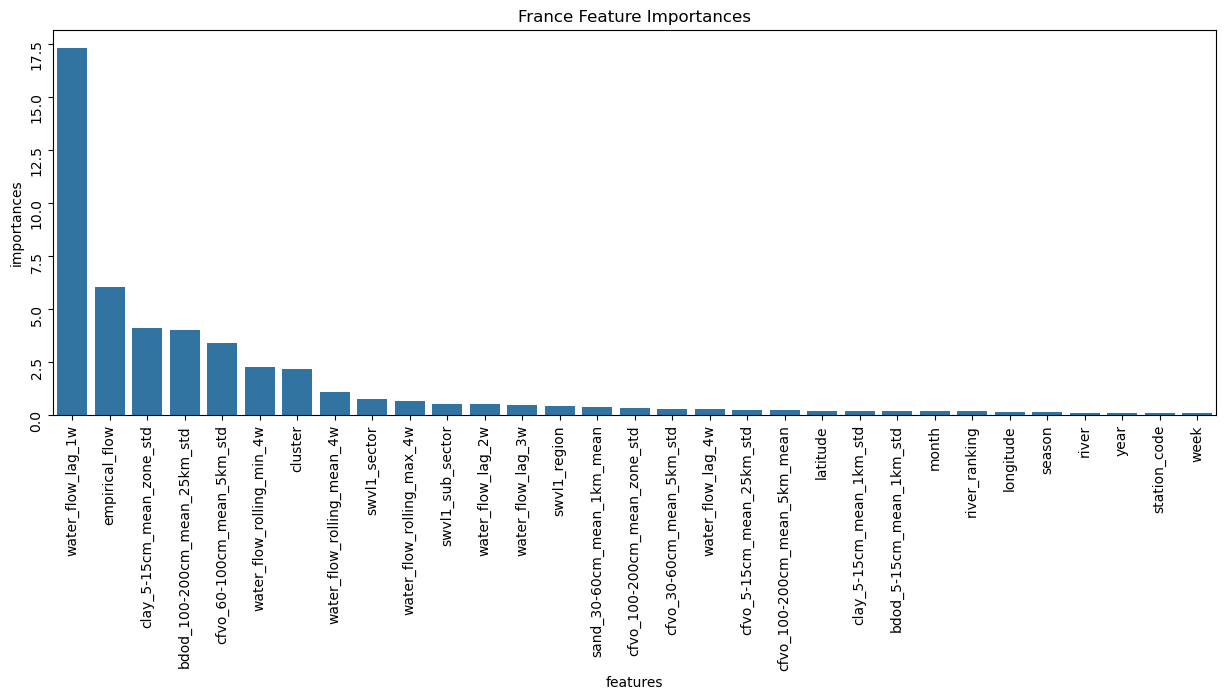

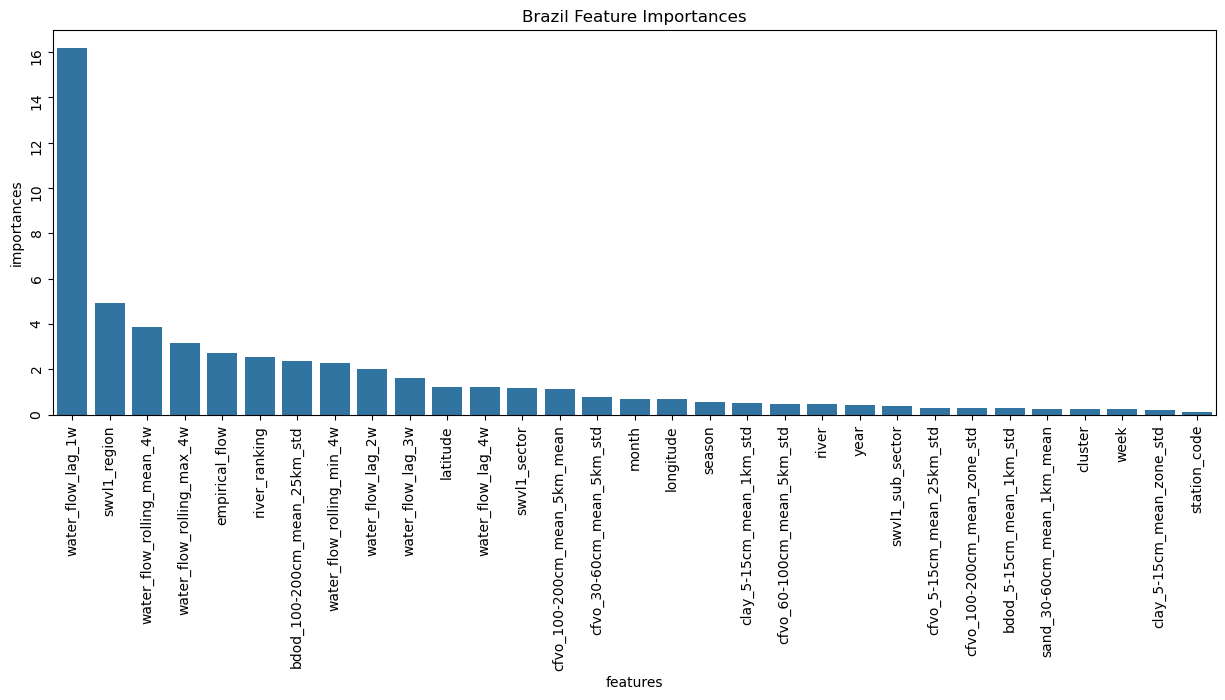

In [148]:
for location, model in models.items():
    feat_importances = model.get_feature_importances_()
    plt.figure(figsize = (15, 5))
    sns.barplot(feat_importances.sort_values('importances', ascending = False).iloc[:50, :], x = 'features', y = 'importances')
    plt.tick_params(rotation = 90)
    plt.title(f'{location.title()} Feature Importances')

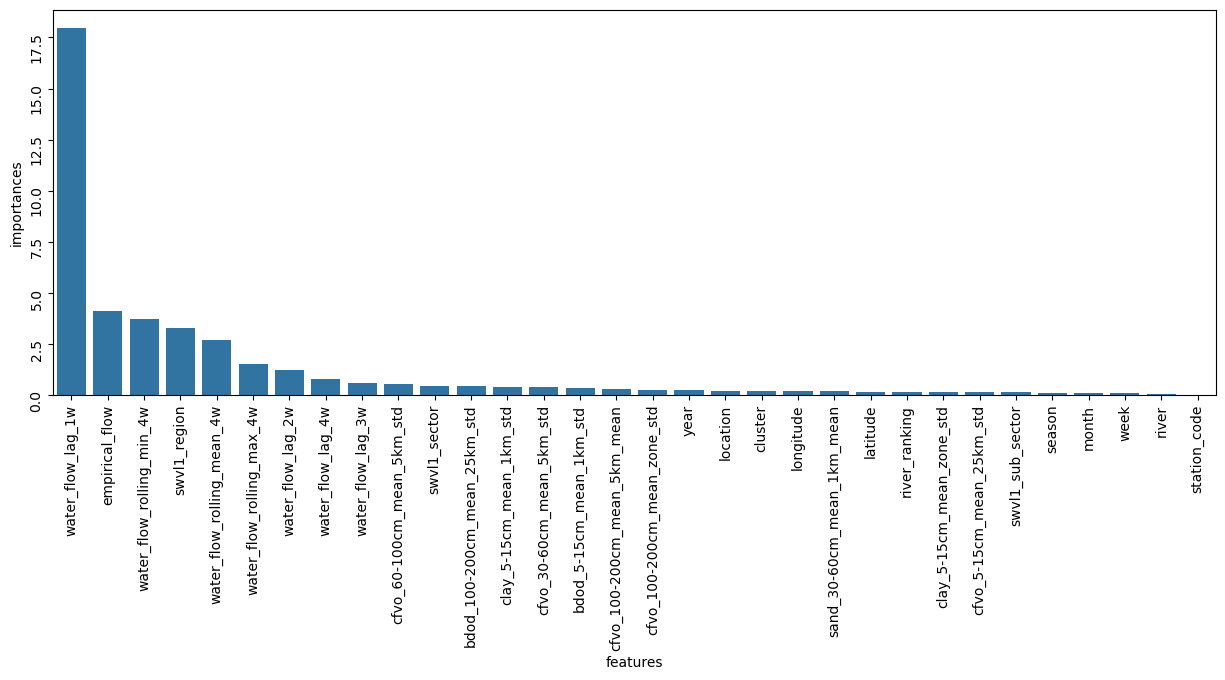

In [97]:
# plt.figure(figsize = (15, 5))
# sns.barplot(feat_importances.sort_values('importances', ascending = False).iloc[:50, :], x = 'features', y = 'importances')
# plt.tick_params(rotation = 90)

In [149]:
for location, model in models.items():
    print(f'{location.title()}: {np.mean(list(model.results.values())):.3f}')

France: 1.676
Brazil: 1.637


In [99]:
# X_train.water_flow_lag_1w.mean(), df_test.water_flow_lag_1w.mean()

In [150]:
X_train.shape, df_test.shape

((28509, 42), (1390, 654))

In [151]:
# set(X_train.columns).symmetric_difference(df_test.columns)

In [152]:
# X_train.columns

In [153]:
X_test = df_test.drop(columns = 'dataset')
# X_test = X_test.drop(columns = X_train.columns)
X_test = X_test[X_train.columns]

In [154]:
X_test.columns

Index(['sand_30-60cm_mean_1km_mean', 'clay_5-15cm_mean_1km_std',
       'cfvo_100-200cm_mean_zone_std', 'clay_5-15cm_mean_zone_std',
       'cfvo_100-200cm_mean_5km_mean', 'cfvo_30-60cm_mean_5km_std',
       'bdod_5-15cm_mean_1km_std', 'cfvo_5-15cm_mean_25km_std',
       'bdod_100-200cm_mean_25km_std', 'cfvo_60-100cm_mean_5km_std',
       'swvl1_sub_sector', 'swvl1_region', 'swvl1_sector', 'water_flow_lag_1w',
       'water_flow_lag_2w', 'water_flow_lag_3w', 'water_flow_lag_4w',
       'water_flow_rolling_mean_4w', 'water_flow_rolling_min_4w',
       'water_flow_rolling_max_4w', 'river', 'location', 'month', 'week',
       'season', 'station_code', 'year', 'latitude', 'longitude',
       'river_ranking', 'ObsDate', 'catchment', 'hydro_region', 'hydro_sector',
       'hydro_sub_sector', 'hydro_zone', 'region_sector', 'region_sub_sector',
       'region_zone', 'sector_sub_sector', 'sector_zone', 'sub_sector_zone'],
      dtype='object')

In [155]:
# X_test.week.dtype, X_test.shape, X_train.shape

In [222]:
%%time
df_output = []
for location, model in models.items():
    X_te = X_test[X_test.location == location]
    df_te = df_test.loc[X_te.index]
    res, _ = model.predict(X_te)
    df_out = []
    for key, value in res.items():
        temp = pd.DataFrame(value, columns = [f'week_{i}_{key}' for i in range(4)], index = X_te.index)
        df_out.append(temp)
    df_out = pd.concat(df_out, axis = 1)
    df_out = df_out.clip(0, np.inf)
    df_out[df_out.filter(like = 'sup').columns] = df_out.filter(like = 'sup').astype('float') + 0.01
    df_out[df_out.filter(like = 'inf').columns] = df_out.filter(like = 'inf').astype('float')# - 0.01
    for i in range(0, 4):
        df_out[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']] = np.sort(df_out[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']].values, axis = 1)
    print(df_out.index, df_te.index)
    df_out = pd.concat([df_out, df_te[['station_code', 'ObsDate']]], axis = 1)
    key = ['pred', 'inf', 'sup']
    df_out = df_out[['station_code'] + [f'week_{i}_{key[j]}' for i in range(4) for j in range(3)] + ['ObsDate']]
    df_output.append(df_out)
df_output = pd.concat(df_output, axis = 0)

/tmp/ipykernel_917805/178073642.py:533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['weights'] = weights
/tmp/ipykernel_917805/178073642.py:533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['weights'] = weights
/tmp/ipykernel_917805/178073642.py:533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

[20.45648408 18.2238101  18.13697689 18.70996902]
[19.07929997 18.53298061 18.92045373 19.93174052]
[20.26391852 19.69344931 19.21286757 18.71745612]
[20.13817129 19.18371482 21.38810433 20.69545662]
[18.97496678 19.20552701 18.53274907 19.20282106]
[18.6496012  17.28115065 17.88422022 19.66084642]
[20.16802441 18.56402319 18.46608265 18.20977337]
[20.20032711 18.37977    17.45364594 16.86670651]
[19.91586904 18.674634   19.41023647 18.18173238]
[20.34080596 17.42562876 16.91819524 16.42205558]
[20.25495824 18.33883834 17.63508929 19.39763431]
[20.50412341 20.73759155 20.93058793 19.172154  ]
[19.97815062 18.32989148 18.72314913 18.82072731]
[20.5717391  18.383832   18.25369241 19.35576433]
[20.30673747 19.90762426 21.13140946 22.39710453]
[19.68769623 19.4802381  20.88484688 22.93417843]
[19.43730595 19.34864095 20.18822602 21.29337556]
[19.49574748 20.06869987 19.6988835  21.45477176]
[20.249566   19.07902561 20.33562507 20.93378047]
[19.29973188 19.49603588 19.89820148 22.58655113]


/tmp/ipykernel_917805/178073642.py:533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['weights'] = weights
/tmp/ipykernel_917805/178073642.py:533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['weights'] = weights
/tmp/ipykernel_917805/178073642.py:533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

[258.1556865  203.86347378 202.1490958  189.70360671]
[247.28642839 208.20408041 227.59346799 187.95539551]
[254.62968181 203.77075999 216.68915726 187.18397683]
[245.49560919 209.54211659 218.89583584 203.24158758]
[273.6539638  233.3915654  212.55631178 216.41258987]
[251.68797369 218.40580511 210.61887661 202.99813268]
[253.9658218  216.43623534 229.60472086 221.70706485]
[265.26497994 236.35344678 223.12089369 210.10360131]
[235.8930403  211.09349596 200.89308522 189.85228472]
[245.62149093 223.17009564 200.05543497 199.51483553]
[264.53496641 214.18545872 201.1633246  206.40449233]
[232.62296694 217.53199444 196.71467176 189.64304683]
[263.06441607 220.28717357 203.71529469 205.42895601]
[247.02075375 215.10777859 203.78335268 188.2287457 ]
[254.9182866  220.53962531 191.33311054 173.57258557]
[272.14873583 241.93357022 200.91123959 187.12995117]
[261.16090249 212.94850089 233.34061341 198.59330027]
[241.54259912 205.46754297 199.01314082 171.58064209]
[259.75416186 230.42533613 1

In [223]:
# %%time
# res, _ = model.predict(X_test)

In [224]:
list(res.values())[0].shape

(376, 4)

In [225]:
# df_output = []
# for key, value in res.items():
#     temp = pd.DataFrame(value, columns = [f'week_{i}_{key}' for i in range(4)])
#     df_output.append(temp)
# df_output = pd.concat(df_output, axis = 1)
# df_output = df_output.clip(0, np.inf)
# df_output[df_output.filter(like = 'sup').columns] = df_output.filter(like = 'sup').astype('float') + 0.01
# df_output[df_output.filter(like = 'inf').columns] = df_output.filter(like = 'inf').astype('float')# - 0.01
# for i in range(0, 4):
#     df_output[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']] = np.sort(df_output[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']].values, axis = 1)
# df_output[['station_code', 'ObsDate']] = df_test[['station_code', 'ObsDate']]
# key = ['pred', 'inf', 'sup']
# df_output = df_output[['station_code'] + [f'week_{i}_{key[j]}' for i in range(4) for j in range(3)] + ['ObsDate']]

In [226]:
df_test.shape

(1390, 654)

In [227]:
df_output[df_output.station_code.isna()]

,station_code,week_0_pred,week_0_inf,week_0_sup,week_1_pred,week_1_inf,week_1_sup,week_2_pred,week_2_inf,week_2_sup,week_3_pred,week_3_inf,week_3_sup,ObsDate


In [228]:
df_output.station_code.unique(), df_output.shape

(array(['6119020', '6119030', '6119040', '6119110', '6119120', '6119200',
        '6124501', '6124510', '6124520', '6125220', '6125230', '6125320',
        '6125440', '6125630', '6125730', '6128630', '6139061', '6139261',
        '6139360', '6139361', '6139520', '6139550', '6139560', '6139640',
        '6139680', '6139681', '6139682', '6139770', '6139790', '6139795',
        '6139825', '6139832', '6139900', '6139910', '6139920', '6139921',
        '6139930', '6139940', '6939050', '56425000', '56539000',
        '56610000', '56659998', '56688080', '56696000', '56719998',
        '56850000', '56920000', '56960005', '56976000', '56978000',
        '56990000', '56992400', '56994500'], dtype=object),
 (1390, 14))

In [229]:
(df_output.week_1_sup - df_output.week_1_inf).mean()

110.20251387962075

In [230]:
X_ = X_train.reset_index(drop = True)

In [231]:
def compute_non_negative_log_likelihood(
    y_true,
    y_pred, 
    y_quantiles,
    station_codes,
    station_stats,
    alpha=.1
):
    """
    Custom log-likelihood scoring function.

    Parameters:
        y_pred : The predictions
        y_quantiles: Prediction Intervals
        y_true : True target values.
        cv_data : Full DataFrame that includes extra columns
        (e.g., "station_code").
        station_stats : Station-level statistics needed for standardization.
        alpha : Significance level (default from ALPHA).

    Returns:
        nll_s : Computed log-likelihood score.
    """
    # Standardize the values.
    y_true_std = standardize_values(
        y_true.to_numpy(),
        station_codes,
        station_stats)
    y_pred_std = standardize_values(
        y_pred,
        station_codes,
        station_stats)
    y_lower_std, y_upper_std = standardize_prediction_intervals(
        y_quantiles,
        station_codes,
        station_stats)

    # Compute sigma from the prediction interval.
    sigma_std = (y_upper_std - y_lower_std) / 3.29
    sigma_std = np.maximum(sigma_std, 1e-6)
    
    # Compute the negative log-likelihood.
    nll_s = (1 / len(y_true_std)) * np.sum(
        np.log(sigma_std) + np.abs(y_true_std - y_pred_std) / (2 * sigma_std)
    )

    # Optionally, print some diagnostics.
    cov = np.mean(
        (y_true_std >= y_lower_std) & (y_true_std <= y_upper_std))
    i_size = np.mean(y_upper_std - y_lower_std)
    print(
        f"Fold: coverage = {cov:.3f}, interval size = {i_size:.3f}")

    return nll_s

In [232]:
# n = 0
# y_true = y_train.iloc[:, n]
# y_pred = df_output.iloc[:, n]
# y_quantiles = df_output[[f'week_{n+1}_inf', f'week_{n+1}_sup']].values
# station_codes = X_train.station_code
# station_stats = get_station_stats(y_true, station_codes)

In [233]:
# np.abs(y_pred - y_true).mean()

In [234]:
# nll = compute_non_negative_log_likelihood(
#     y_true,
#     y_pred, 
#     y_quantiles,
#     station_codes,
#     station_stats,
#     alpha = 0.1
# )
# nll

In [235]:
# df.groupby('location').water_flow_week_1.quantile([0, 0.25, 0.5, 0.75, 1])

In [236]:
# df_test.groupby('location').station_code.nunique()

In [237]:
X_train.shape

(28509, 42)

In [238]:
set(X_train.station_code).symmetric_difference(set(X_test.station_code))

{'56539000',
 '56688080',
 '56696000',
 '56719998',
 '56990000',
 '56992400',
 '6119030',
 '6124520',
 '6125230',
 '6125730',
 '6128630',
 '6139680',
 '6139682',
 '6139832',
 '6139930'}

6119020 GAVE D'OSSAU


/tmp/ipykernel_917805/779844926.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp_X['ObsDate'] = pd.to_datetime(samp_X.ObsDate.values)
/tmp/ipykernel_917805/779844926.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp_X_true['ObsDate'] = pd.to_datetime(samp_X_true.ObsDate.values)


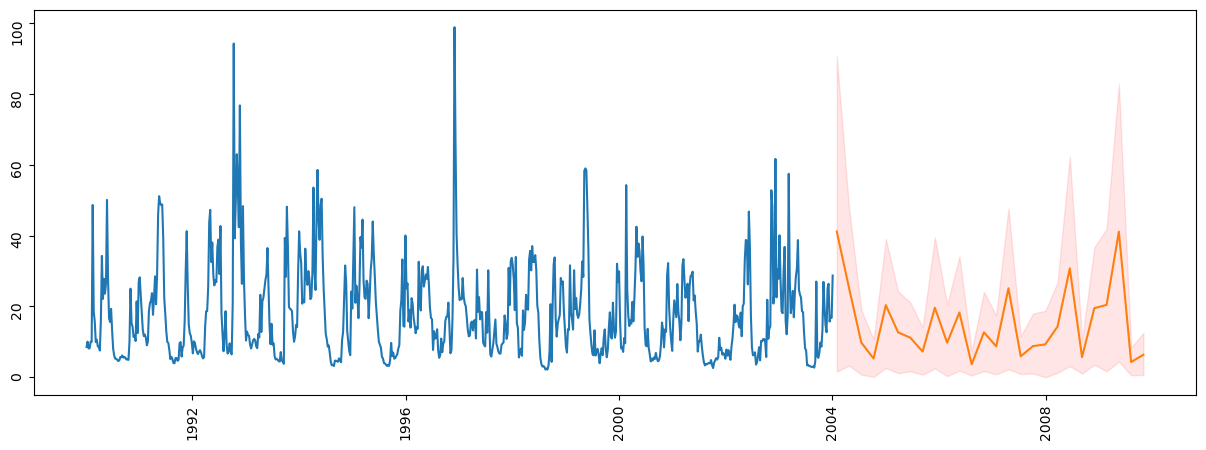

In [239]:
n = 0
j = 0 #12
station_codes = df_test.station_code.unique()
plt.figure(figsize = (15, 5))
samp_X = df_test[df_test.station_code == station_codes[j]] #'56610000'] #
samp_X_true = X_train[X_train.station_code == station_codes[j]]
samp_X['ObsDate'] = pd.to_datetime(samp_X.ObsDate.values)
samp_X_true['ObsDate'] = pd.to_datetime(samp_X_true.ObsDate.values)
samp_y_true = y_train.loc[samp_X_true.index]
pred_y = df_output.loc[samp_X.index]
plt.plot(samp_X_true.ObsDate, samp_y_true.iloc[:, n].values);
plt.plot(samp_X.ObsDate, pred_y.loc[:, f'week_{n+1}_pred'])
plt.fill_between(samp_X.ObsDate, pred_y.loc[:, f'week_{n+1}_inf'], pred_y.loc[:, f'week_{n+1}_sup'], color = 'red', alpha = 0.1)
plt.tick_params(rotation = 90)
print(station_codes[j], samp_X.river.unique()[0])

In [240]:
df_output.drop(columns = ['station_code', 'ObsDate']).mean()

week_0_pred     82.269761
week_0_inf      26.268178
week_0_sup     141.034002
week_1_pred     73.283945
week_1_inf      20.684734
week_1_sup     130.887248
week_2_pred     69.906967
week_2_inf      18.708475
week_2_sup     127.690756
week_3_pred     67.067543
week_3_inf      16.951175
week_3_sup     123.057443
dtype: float64

In [122]:
# df_output.drop(columns = ['station_code', 'ObsDate']).mean()

week_0_pred     86.011473
week_0_inf      30.281315
week_0_sup     144.384341
week_1_pred     77.255323
week_1_inf      23.465092
week_1_sup     134.415253
week_2_pred     71.605456
week_2_inf      20.156794
week_2_sup     127.747776
week_3_pred     68.719853
week_3_inf      18.798708
week_3_sup     123.421046
dtype: float64

In [241]:
df_output.to_csv('predictions.csv', index = False)